# Constants

Here we define some Constants and some utilities

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import logging 
logging.basicConfig(format='\r%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)
 
NUM_CASES = 500

cnt = 1
last_action = ""
def counter_message(max_cnt, action):
    """Displays Progress of an action
    """
    global cnt, last_action
    
    #Reset Counter for every new action
    if last_action != action:
        cnt = 1
        last_action = action
    
    #Print Message
    print("\r{}/{}: {}.".format(cnt, max_cnt, action), end=" "*10, flush=True)
    cnt += 1
    
%matplotlib inline

# Task 1
Here we train Word2Vec on our corpus, once with a small window (e.g. 2) and again with a long window (e.g. 16).

I expect the window size of 2 to be too much, as most of the legal language used is not that simple and it will not be able to get the full context of the sentence. However a window size of 16 is probably a bit too much, which could yet again lead to a loss in performance if there are too many words associated with a word.

At first we have to read the documents into a useable format. We use our old friend spacy to load and lemmatize them before feeding them to Word2Vec.

In [2]:
from zipfile import ZipFile
import spacy
import numpy as np
import string

def normalize(token):
    """Normalize Token. Get Lemma (base form) and remove any punctuation
    """
    lemma = token.lemma_
    nopunct = lemma.translate(str.maketrans('', '', string.punctuation)).strip()
    return nopunct

nlp = spacy.load('en') # requires:python -m spacy download en

zfile = ZipFile("data/cases.zip")
cases = zfile.namelist()
spacy_documents = {}
case_ids = []

# Set NUM_CASES to max if its None
if NUM_CASES is None:
    NUM_CASES = len(cases)    
cases = np.random.permutation(cases)[:NUM_CASES]

# Load cases into spacy documents
for case in cases:
    year, caseid = case[:-4].split("_")
    with zfile.open(case) as f:
        spacy_documents[caseid] = nlp(f.read().decode())
    case_ids.append(caseid)
    counter_message(len(cases),"Read into spacy document")

# Lemmatize documents
lemmatized_documents = {}
for caseid, spacy_document in spacy_documents.items():
    lemmatized_documents[caseid] = []
    for token in spacy_document:
        lemmatized_documents[caseid].append(normalize(token))
    counter_message(len(spacy_documents),"Lemmatized Token")

500/500: Lemmatized Token.                                                                                        

Next we use gensim's Word2Vec to train our models on all of the documents we have. We use the parameter `size = 2` which means the vectors will have dimension 2 which is ideal for displaying the words in the later task.

In [3]:
import gensim
model2 = gensim.models.Word2Vec(list(lemmatized_documents.values()),window=2,size=2)
model16 = gensim.models.Word2Vec(list(lemmatized_documents.values()),window=16,size=2)

2019-05-15 14:33:32,737 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-05-15 14:33:37,482 : WARNING : consider setting layer size to a multiple of 4 for greater performance


Now that we have trained our model we use matplotlib to plot the 50 most common words which are either nouns, adjectives or verbs on a 2D plane. We had to significantly upscale the plots by using `dpi=200` in order to make the many words readable.

I only looked at the 50 most common words instead of 100 as stated in the question, because it is otherwise almost impossible to read the words on the plot, even after upscaling it.

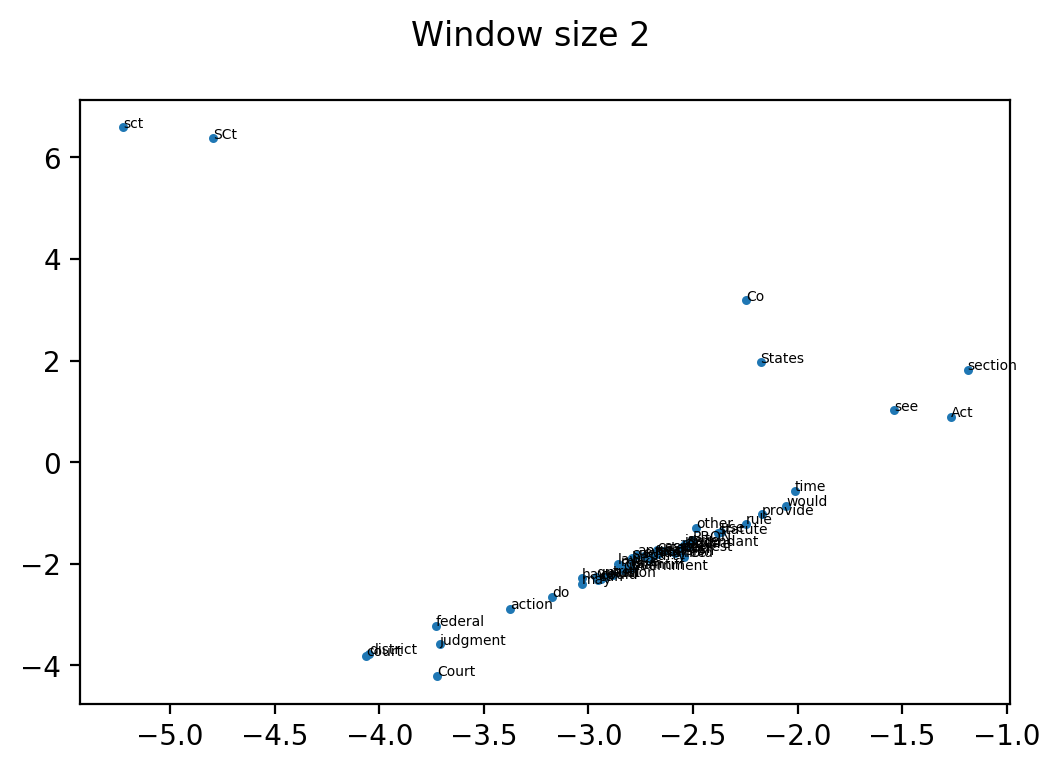

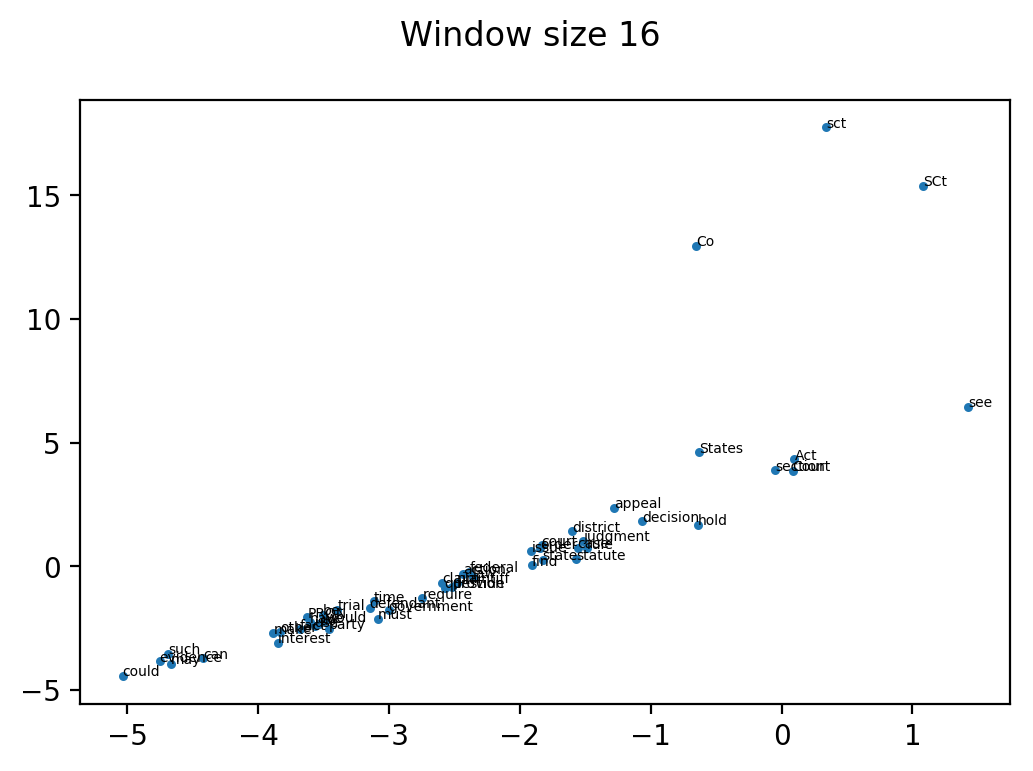

In [4]:
from matplotlib import pyplot as plt

# How many words should be displayed
n_words = 50

# Creates a list of the most frequently used words which are either an adjective, noun or verb
most_frequent = []
for word in model2.wv.index2entity:
    doc = nlp(word)
    if len(doc) > 0 and (doc[0].pos_ in ["NOUN","ADJ","VERB"]):
        most_frequent.append(word)
    if len(most_frequent) == n_words:
        break
        
# Create arrays with the corresponding coordinates
x2 = []
y2 = []
x16 = []
y16 = []
for word in most_frequent:
    wx2, wy2 = model2[word]
    x2.append(wx2)
    y2.append(wy2)
    wx16, wy16 = model16[word]
    x16.append(wx16)
    y16.append(wy16)

# Plot
fig2, ax2 = plt.subplots(dpi=200)
fig2.suptitle("Window size 2")

fig16, ax16 = plt.subplots(dpi=200)
fig16.suptitle("Window size 16")

ax2.scatter(x2, y2, s = 5)
ax16.scatter(x16, y16, s = 5)

# Annotate the corresponding words on top of the dots
for i, txt in enumerate(most_frequent):
    ax2.annotate(txt, (x2[i], y2[i]),fontsize=5)
    ax16.annotate(txt, (x16[i], y16[i]),fontsize=5)

We can see, that the first plot with the window size 2 has a much narrower understanding of what words belong together. There words that often apperar next to echother or belong to a phrase, such as "federal Court" are close to eachother, but we cannot extract much more information than that.
The second plot with the window size 16 has a much broader understanding so these words do not necessarily have to be as close together as on the first plot. But in turn, there are more remotely connected words that appear close together, such as "decision" and "judgement".
I believe, that this plot would have worked a bit better with more than 500 cases as input. However I was limited by the speed and memory used by spacy, so I could not add more cases for training the model. Another improvement might have been achieved if we chose more than two dimension for the model and then reduced the dimensionality using PCA.

# Task 2

In this task I train separate word embeddings for Republican and Democrat judges. I then use these embeddings to list the adjectives most associated with a social group or concept of my choice.

At first we read the metadata. To save time on Task 3, we already load all metadata into their own dictionaries, even if we do not need them yet. We also create two new arrays with either documents from cases of republican or from non republican judges which we can then use to train our two models.

In [5]:
import pandas as pd

# Load metadata and fill Nan with 0
metadata = pd.read_csv("data/case_metadata.csv").fillna(0)

republican_documents = []
nonrepublican_documents = []

judge_revs = {}
judge_ids = {}
judge_years = {}
judge_reps = {}
judge_cites = {}

# Extract metadata
for caseid, rev, judge_id, year, rep, log_cite  in metadata.values:
    # Split up all lemmatized documents into two arrays based on wether their judge was republican or not.
    if caseid in lemmatized_documents:
        if rep == 1:
            republican_documents.append(lemmatized_documents[caseid])
        else:
            nonrepublican_documents.append(lemmatized_documents[caseid])
    # We put all metadata into their own dictionary, even though we don't need all of them, just in case
    #  that we would like to train on different data in the future.
    judge_revs[caseid]  = rev 
    judge_ids[caseid]   = judge_id
    judge_years[caseid] = year
    judge_reps[caseid]  = rep
    judge_cites[caseid] = log_cite
    counter_message(len(metadata.values),"Read Metadata")

5949/5949: Read Metadata.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

We now use these documents to train two models on the republican and the nonrepublican cases. We then get the top ten adjectives associated with the word "man" for both the republican and the non-republican judges

In [6]:
def get_most_similar(model, word, n=10, word_types=["ADJ"]):
    """Gets the n most similar Adjective to a specific word
    """
    out = []
    for word, score in model.wv.most_similar(word,topn=1000):
        doc = nlp(word)
        if len(doc) > 0 and (doc[0].pos_ in word_types):
            out.append(word)
        if len(out) > n:
            break
    return out

group = "man"

# Train two models on republican and non-republican judges. I chose the window size 5 as a compromise between the 
#  small (2) and the large (16) window size used in the previous task.
model_rep = gensim.models.Word2Vec(republican_documents,window=5)
model_nonrep = gensim.models.Word2Vec(nonrepublican_documents,window=5)

most_similar_rep = get_most_similar(model_rep, group)
most_similar_nonrep = get_most_similar(model_nonrep, group)

print("Most similar Adjectives to {} for Republican Judges:\n{}".format(group, most_similar_rep))
print()
print("Most similar Adjectives to {} for non-Republican Judges:\n{}".format(group, most_similar_nonrep))

Most similar Adjectives to man for Republican Judges:
['fair', 'open', 'patient', 'extra', 'large', 'current', 'impossible', 'lawful', 'claimant', 'short', 'competitive']

Most similar Adjectives to man for non-Republican Judges:
['potential', 'small', 'urban', 'few', 'high', 'racial', 'confidential', 'illegal', 'equivalent', 'select', 'mental']


I cannot see any big differences between the two political parties on how they describe men in general. There are certainly differences in the meaning of the adjectives but 500 cases are not enough to definitely get an actual difference that is not caused by the sample of cases that we chose.

# Task 3

In this task I look at the effect of political party on citations usig the double ML method.

At first we have to create the Machine learning featers. We generate the 3-grams of them and store the most common 3-grams frequencies in the corresponding arrays. We also store the wether the judge is a republican and the log cites of this case in two seperate arrays, so that we can use them for Machine Learning afterwards.

In [7]:
from nltk import ngrams
import string
import pandas as pd
from collections import Counter

noun_ngrams = {}
total_ngrams = []
word_counts= {}

# Lemmatize Cases
for caseid in case_ids:
    tokens = []
    spacy_document = spacy_documents[caseid]
    for token in spacy_document:
        if not token.is_punct and not token.is_space: # Ignore spaces (newlines etc) and punctuation
            tokens.append(token)
            norm = normalize(token)
            
            if not norm in word_counts: # We've seen the word for the first time
                word_counts[norm] = 1
            else:                       # We already know this word
                word_counts[norm] += 1

    noun_ngram = []
    for ngram in ngrams(tokens, 3): # iterate over all 3-grams
        if ngram[2].pos_ == "NOUN": # check if last word is a noun
            curr_ngram = (normalize(ngram[0]),
                               normalize(ngram[1]),
                               normalize(ngram[2]))
            noun_ngram.append(curr_ngram)   # Stores 3-grams for this case
            total_ngrams.append(curr_ngram) # Stores 3-grams for all cases
    
    noun_ngrams[caseid] = noun_ngram
    counter_message(NUM_CASES, "Extracted 3-Grams")

# Load outcomes into dictionary
outcomes = {}
case_reversed = pd.read_csv("data/case_reversed.csv").values
for caseid, outcome in case_reversed:
    outcomes[caseid] = outcome

X = []
y = []
t = []

# Get most common n_grams
most_common = Counter(total_ngrams).most_common()

# Create the ML features
for caseid in case_ids:
    current_ngram = Counter(noun_ngrams[caseid])
    features = np.zeros(len(most_common))
    for i in range(len(most_common)):
        ngram = most_common[i][0]
        if ngram in current_ngram: #Only add most common 3-gram frequencies
            features[i] = current_ngram[ngram]
    X.append(features)
    y.append(judge_reps[caseid])
    t.append(judge_cites[caseid])
    counter_message(NUM_CASES, "Created ML features")

# convert to numpy array
X = np.array(X)

#standardize; maintain sparsity by not taking out the mean
X = X / np.std(X, axis=0)
y = np.array(y)
t = np.array(t)

500/500: Created ML features.                                                                                                 

Next we use the duble ML method discussed in class in order to get the effect of a judge being a republican on the log citations.

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

#Shuffle Dataset
permutation = np.random.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
t = t[permutation]

# Divde the dataset into two splits
split = int(X.shape[0]*.5)

A = X[:split]
y_a = y[:split]
t_a = t[:split]

B = X[split:]
y_b = y[split:]
t_b = t[split:]

def get_effect(A, B, y_a, y_b,t_a, t_b):
    """Gets the effect that one feature has on another
    """
    reg_y_a = LinearRegression().fit(A, y_a)
    reg_t_a = LinearRegression().fit(A, t_a)

    diff_y_b = (y_b - reg_y_a.predict(B)).reshape(-1,1)
    diff_t_b = (t_b - reg_t_a.predict(B)).reshape(-1,1)
    
    reg_y_t = LinearRegression().fit(diff_y_b, diff_t_b)
    return reg_y_t.score(diff_y_b, diff_t_b)

# Calculate effect in both directions, then take the average of both
effect_a = get_effect(A,B,y_a,y_b,t_a,t_b)
effect_b = get_effect(B,A,y_b,y_a,t_b,t_a)
average = (effect_a + effect_b) / 2

print("The effect of a judge being a republican on its log citations is {:.3f}".format(average))

The effect of a judge being a republican on its log citations is 0.035


This example shows us, that being a republican has very little impact on the log citations of his case.